In [ ]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


In [7]:
from keras.models import load_model
from keras_retinanet import models

model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv('classes.csv', header=None).T.loc[0].to_dict()

snapshots\resnet50_csv_50.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [

In [3]:
test_df = pd.read_csv("annotations_test.csv")
test_df.head()

,images/116.png,35,18,197,212,left
0,images/25.png,41,21,201,199,left
1,images/125.png,35,38,189,170,left
2,images/78.png,44,59,208,189,left
3,images/147.png,87,133,155,198,left
4,images/12.png,32,14,210,191,left


In [4]:
import skimage.io as io

def predict(image):
    image = preprocess_image(image.copy())
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
     np.expand_dims(image, axis=0)
     )

    boxes /= scale

    return boxes, scores, labels

umbralScore = 0.95

def draw_detections(image, boxes, scores, labels):
      for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < umbralScore:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

images/25.png 0


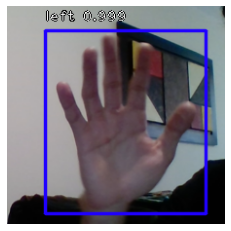

images/125.png 1


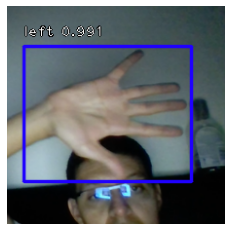

images/78.png 2


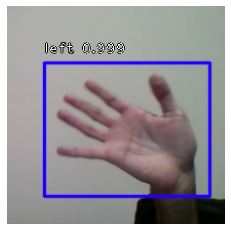

images/147.png 3


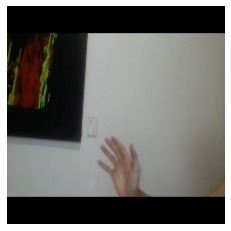

images/12.png 4


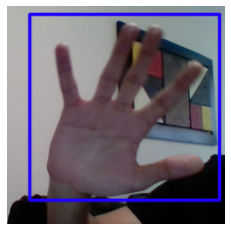

images/77.png 5


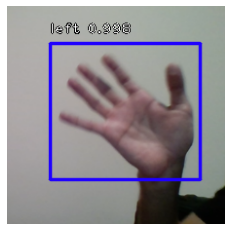

images/138.png 6


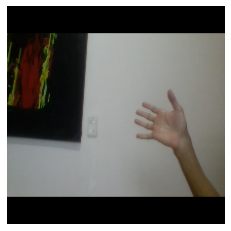

images/107.png 7


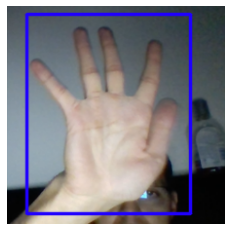

images/182.png 8


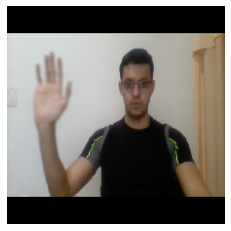

images/179.png 9


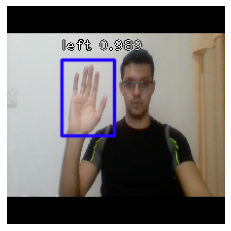

images/204.png 10


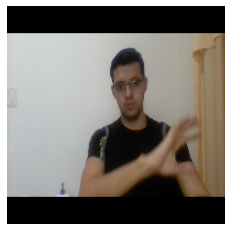

images/206.png 11


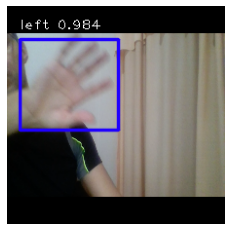

images/197.png 12


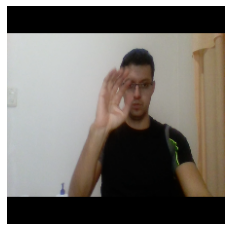

images/20.png 13


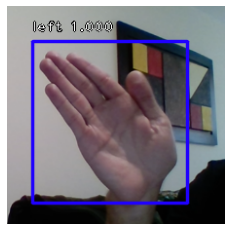

images/36.png 14


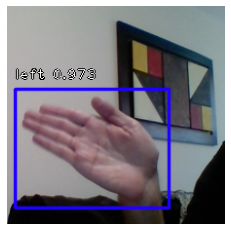

images/194.png 15


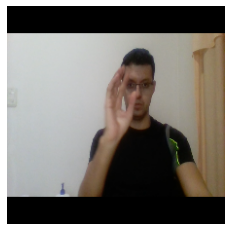

images/157.png 16


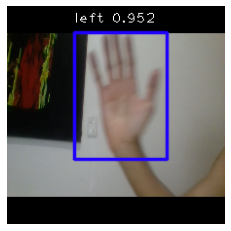

images/156.png 17


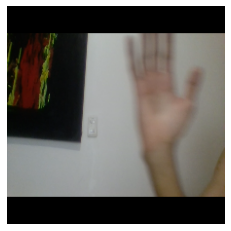

images/11.png 18


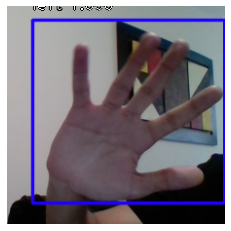

images/13.png 19


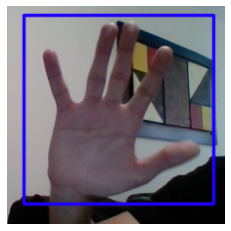

images/71.png 20


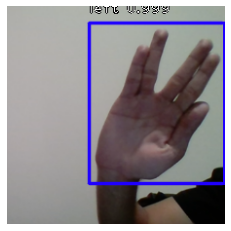

images/97.png 21


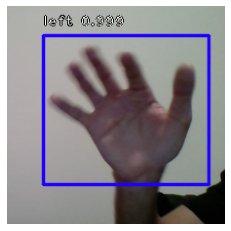

images/26.png 22


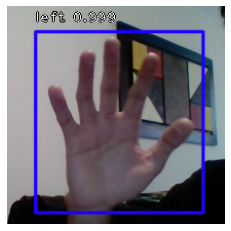

images/175.png 23


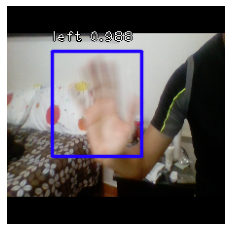

images/168.png 24


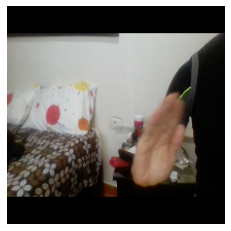

images/18.png 25


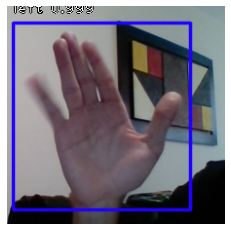

images/119.png 26


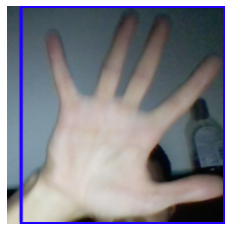

images/158.png 27


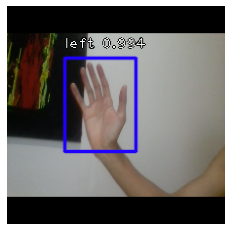

images/22.png 28


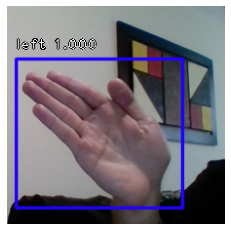

images/53.png 29


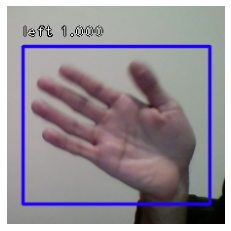

images/162.png 30


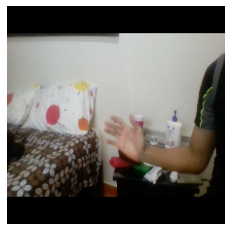

images/213.png 31


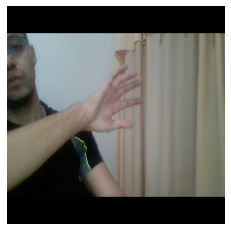

images/86.png 32


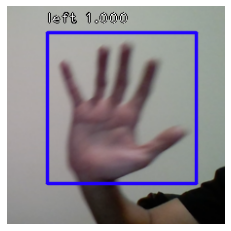

images/3.png 33


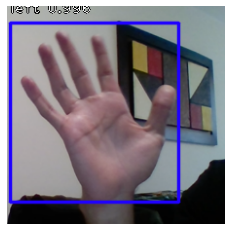

images/83.png 34


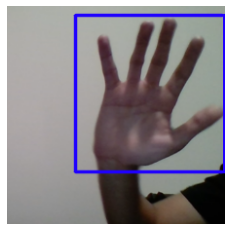

images/120.png 35


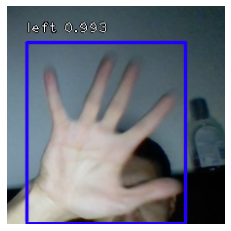

images/219.png 36


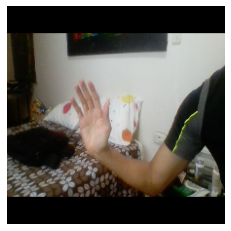

images/224.png 37


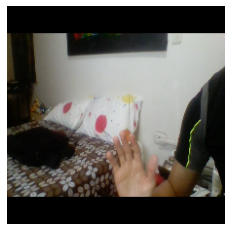

images/135.png 38


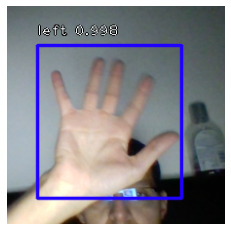

images/47.png 39


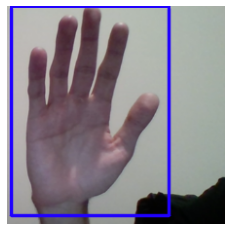

images/8.png 40


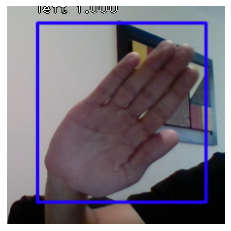

images/103.png 41


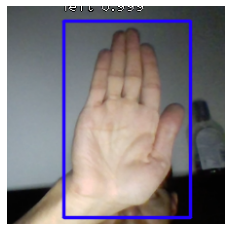

images/123.png 42


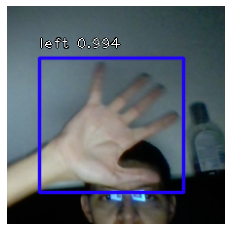

images/109.png 43


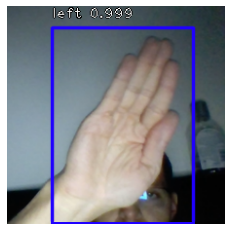

images/124.png 44


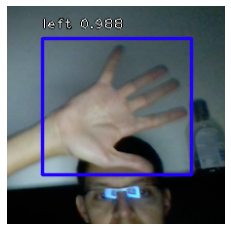

images/227.png 45


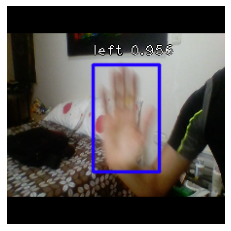

In [5]:
for index, row in test_df.iterrows():
    print(row[0], index)
    image = io.imread(row[0])
    #image = io.imread('images/hand2.jpg')

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [10]:
# get the reference to the webcam
camera = cv2.VideoCapture(0)
camera_height = 500

while(True):
    # read a new frame
    _, frame = camera.read()
    
    # flip the frameq
    frame = cv2.flip(frame, 1)

    # rescaling camera output
    #aspect = frame.shape[1] / float(frame.shape[0])
    #res = int(aspect * camera_height) # landscape orientation - wide image
    #frame = cv2.resize(frame, (res, camera_height))
    
    boxes, scores, labels = predict(frame)

 
    draw = frame.copy()
   # draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    #draw_detections(draw, boxes, scores, labels)

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score > 0.8:
            print(box)
            b = box.astype(int)
            color = label_color(label)
            draw_box(draw, b, color=color)
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            
    #plt.axis('off')
    #plt.imshow(draw)
    #plt.show()

    # show the frame
    cv2.imshow("Test out", draw)
    #cv2.imshow("Test out2", roi)

    key = cv2.waitKey(1)

    # quit camera if 'q' key is pressed
    if key & 0xFF == ord("q"):
        break

camera.release()
cv2.destroyAllWindows()

[159.12984  76.04654 416.6227  328.12076]
[325.0677  180.23183 467.52087 323.27005]
[131.93095 165.19576 258.01465 334.59717]
[361.29376 169.17763 548.291   401.31168]
[  0.      196.68015 163.07295 409.95068]
[351.24338 175.08427 537.8965  397.66104]
[  0.      200.71616 163.85913 414.81207]
[336.93237 172.98871 524.68195 401.7655 ]
[  0.      202.86363 181.85861 411.04465]
[394.96185 153.86467 587.7256  378.52542]
[  0.      174.54352 117.3531  400.7471 ]
[397.17157 150.82187 579.4959  369.1285 ]
[392.8101  149.83891 578.7247  367.22763]
[  0.      170.92665 130.11244 382.66364]
[390.6569  150.23431 578.96686 371.77527]
[423.7463  203.87297 604.38586 407.91183]
[420.0464  186.89648 604.0378  402.35812]
[411.39227 173.56126 599.64795 387.87283]
[415.0357  171.275   601.1809  390.92282]
[414.285   171.65065 603.02844 395.94296]
[413.8905  170.52745 598.7481  384.12552]
[410.48914 160.12462 599.23584 385.9136 ]
[390.32278 154.06161 583.60443 380.3261 ]
[381.10706 153.57935 572.733   367

[388.7632  148.0664  538.7033  333.93826]
[389.27252 147.32982 539.7955  334.8438 ]
[393.323   147.54672 541.566   334.43774]
[395.80807 149.4932  544.8961  340.67783]
[396.89935 148.40433 544.7874  341.7118 ]
[395.00894 144.3832  546.5638  340.2275 ]
[397.286   144.24817 549.2704  336.33447]
[396.13687 144.833   545.6893  332.7581 ]
[397.4525  144.63007 547.5714  333.9128 ]
[395.26987 144.78505 547.7491  335.20847]
[396.1329  145.04967 544.22473 334.6749 ]
[396.4582  143.89204 544.53296 335.98148]
[396.67288 143.25883 543.8365  330.4546 ]
[385.38776 132.83832 556.7106  336.85233]
[383.80112 129.46547 554.929   333.8314 ]
[380.55093 128.34836 553.8626  334.31094]
[380.58655  127.894196 550.5893   325.80923 ]
[379.63235 129.45346 549.314   329.35083]
[380.71503 128.51634 552.98474 329.44995]
[383.90823 129.30832 552.5599  325.29504]
[385.26758 130.88202 547.1563  322.7439 ]
[388.29352 134.54587 546.5592  322.87497]
[386.98505 133.3934  548.5375  327.25336]
[387.0878  135.64476 547.9757 

[371.1256  132.47594 534.8619  330.60315]
[373.3516  136.03763 538.51526 329.64175]
[389.2549  136.93208 539.5858  327.58383]
[398.60843 142.50282 536.98914 325.21738]
[396.19122 140.86386 537.238   325.6981 ]
[398.53354 143.19705 534.97064 328.0567 ]
[396.711   140.03596 536.4531  326.3117 ]
[398.58298 140.42566 536.6984  326.11618]
[397.2948  139.29979 536.2063  326.22678]
[394.93295 136.46812 540.45233 328.55255]
[389.60367 134.61183 544.8855  327.62552]
[386.82632 137.72516 544.1865  325.8656 ]
[386.80185 135.47813 544.87946 330.68237]
[390.30338 136.57533 544.3305  328.489  ]
[389.9273  136.77576 545.4512  325.44702]
[391.31168 137.27191 545.32526 326.02615]
[391.6832  137.12704 545.7016  323.52335]
[395.9209  133.86429 544.4995  322.86264]
[394.93228 134.48485 546.5104  325.52005]
[394.6325  135.07101 545.07697 326.0086 ]
[394.27222 135.74428 546.2507  326.4347 ]
[394.78406 135.29253 548.2485  325.91107]
[394.79715 135.12982 547.52216 325.92172]
[395.51395 134.69527 547.1644  326

In [ ]:
camera.release()